In [187]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# this is for datetime plotting with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [188]:
df = pd.read_csv("./datasets/Alcohol_Sales.csv", index_col=0, parse_dates=True)
df.sample(5)

,S4248SM144NCEN
DATE,
2012-10-01,10754
1994-06-01,4985
2015-02-01,9062
2014-08-01,10981
2014-09-01,10828


In [189]:
# remove null values (none here)
df = df.dropna()
df.shape

(325, 1)

<AxesSubplot: xlabel='DATE'>

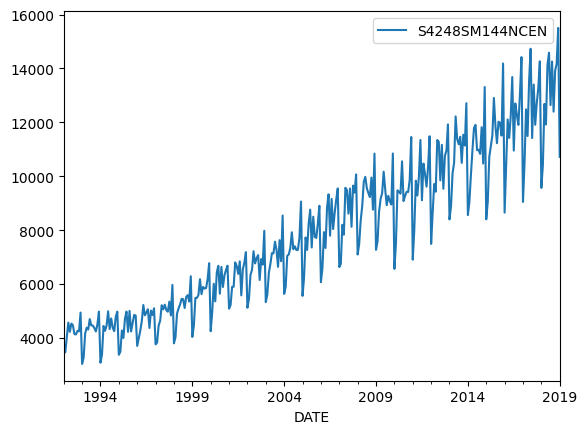

In [190]:
df.plot()

(260, 1)
(65, 1)


<AxesSubplot: xlabel='DATE'>

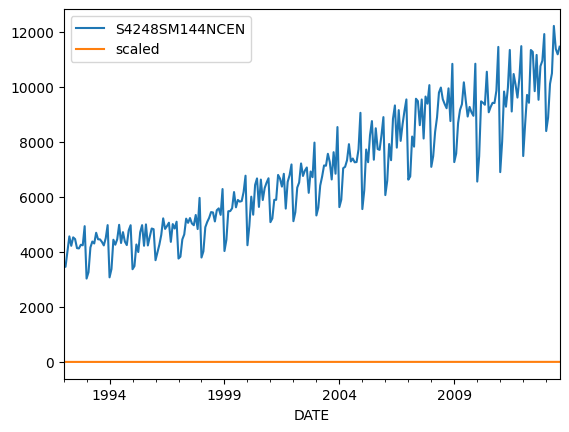

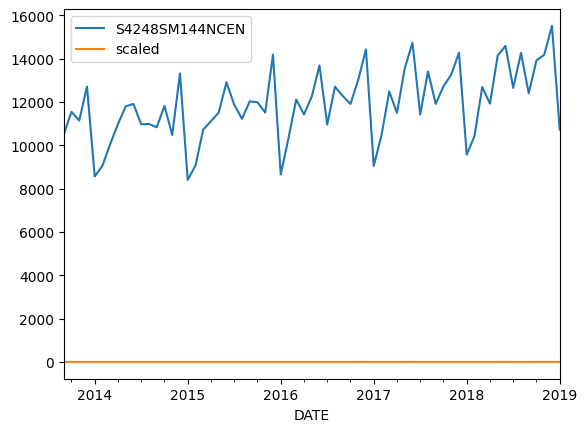

In [191]:
# normalize the data
from sklearn.preprocessing import MinMaxScaler

train_cutoff = int(len(df)*.8)
train_df = df[:train_cutoff].copy()
test_df = df[train_cutoff:].copy()

print(train_df.shape)
print(test_df.shape)

scaler = MinMaxScaler(feature_range=(-1,1))

unscaled_train = torch.tensor(train_df.values.reshape(-1,1))
scaled_train = scaler.fit_transform(unscaled_train)

unscaled_test = torch.tensor(test_df.values.reshape(-1,1))
scaled_test = scaler.transform(unscaled_test)

train_df['scaled'] = scaled_train
test_df['scaled'] = scaled_test

train_df.plot()
test_df.plot()


In [192]:
# turn data into time series data

df = df.sort_index()

def get_data(df_input, window_size=10):

    # time window of 10
    tdata = df_input['scaled'].tolist()

    xs = []
    ys = []
    for idx, i in enumerate(range(0, len(tdata)-window_size-1)):
        x = tdata[idx: idx + window_size]
        y = tdata[idx+window_size]
        xs.append(x)
        ys.append(y)

    for idx, seq in enumerate(xs):
        if 0 < idx < len(xs)-1:
            assert(xs[idx+1][-1] == ys[idx])

    inputs = torch.tensor(xs).type(torch.float32)
    targets = torch.tensor(ys).type(torch.float32)

    return inputs, targets

window_size = 13
X_train, y_train = get_data(train_df, window_size)
print(f"train size {train_df.shape}")
print(X_train.shape)
print(y_train.shape)

X_test, y_test = get_data(test_df, window_size)
print(f"test size {test_df.shape}")
print(X_test.shape)
print(y_test.shape)


train size (260, 2)
torch.Size([246, 13])
torch.Size([246])
test size (65, 2)
torch.Size([51, 13])
torch.Size([51])


In [207]:
# define architecture

class AlcoholLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=2,
            dropout=.01
            )

        self.fc = nn.Linear(self.hidden_size, self.output_size)

        h = torch.zeros(2, 1, self.hidden_size)
        self.hidden = (h,h)

    def forward(self, seq):

        seq = seq.view(len(seq),1,-1)
        lstm_out, self.hidden = self.lstm(seq, self.hidden)
        out = self.fc(lstm_out.view(len(seq), -1))

        return out[-1]

model = AlcoholLSTM()
print(model)

# test a forward pass
seq = X_train[0]
print(f"seq input size: {seq.shape}")
pred = model.forward(seq)
print(pred)

AlcoholLSTM(
  (lstm): LSTM(1, 100, num_layers=2, dropout=0.01)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
seq input size: torch.Size([13])
tensor([0.0356], grad_fn=<SelectBackward0>)


In [208]:
# train model
torch.random.manual_seed(101)
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [209]:
pred = model.forward(seq)
print(pred.squeeze())
print(y_train[0])

tensor(0.0360, grad_fn=<SqueezeBackward0>)
tensor(-0.9499)


In [210]:
import time
epochs = 200
start_time = time.time()
for e in range(0, epochs):
    for idx, seq in enumerate(X_train):
        optimizer.zero_grad()

        h = torch.zeros(2, 1, model.hidden_size)
        model.hidden = (h,h)

        y_pred = model(seq)
        loss = criteria(y_train[idx], y_pred.squeeze())
        loss.backward()
        optimizer.step()

    print(f"epoch: {e} loss:{loss.item()}")

epoch: 0 loss:0.018630199134349823
epoch: 1 loss:0.015234055928885937
epoch: 2 loss:0.02389121614396572
epoch: 3 loss:0.02417144365608692
epoch: 4 loss:0.031187953427433968
epoch: 5 loss:0.0230371356010437
epoch: 6 loss:0.22022484242916107
epoch: 7 loss:0.47957703471183777
epoch: 8 loss:0.570094108581543
epoch: 9 loss:0.563178539276123
epoch: 10 loss:0.06674165278673172
epoch: 11 loss:0.021758249029517174
epoch: 12 loss:0.015708766877651215
epoch: 13 loss:0.024117393419146538
epoch: 14 loss:0.10049434751272202
epoch: 15 loss:0.42273616790771484
epoch: 16 loss:0.5632809996604919
epoch: 17 loss:0.5921319127082825
epoch: 18 loss:0.6080768704414368
epoch: 19 loss:0.619102954864502
epoch: 20 loss:0.627059817314148
epoch: 21 loss:0.2536037266254425
epoch: 22 loss:0.03326866775751114
epoch: 23 loss:0.04913070797920227
epoch: 24 loss:0.02750641480088234
epoch: 25 loss:0.039154428988695145
epoch: 26 loss:0.049808911979198456
epoch: 27 loss:0.048526111990213394
epoch: 28 loss:0.02671722881495952

In [211]:
len(X_train[-1].tolist())

13

In [212]:
future = 12
preds = train_df.scaled[-window_size:].tolist()
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        h = torch.zeros(2, 1, model.hidden_size)
        model.hidden = (h,h)
        preds.append(model(seq).item())

tpreds = torch.FloatTensor(preds[window_size:])
true_preds = scaler.inverse_transform(tpreds.reshape(-1,1))
#true_preds

In [213]:
train_df.scaled[-window_size:]

DATE
2012-08-01    0.770328
2012-09-01    0.415261
2012-10-01    0.681289
2012-11-01    0.724611
2012-12-01    0.935561
2013-01-01    0.167737
2013-02-01    0.275063
2013-03-01    0.541091
2013-04-01    0.624469
2013-05-01    1.000000
2013-06-01    0.818657
2013-07-01    0.775335
2013-08-01    0.835420
Name: scaled, dtype: float64

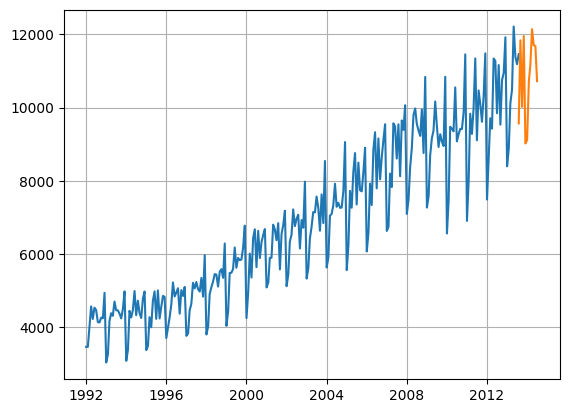

In [214]:
x = np.arange('2013-08-02', '2014-08-02', dtype='datetime64[M]')

plt.plot(train_df.S4248SM144NCEN)
plt.plot(x, true_preds)
plt.grid()